In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt
from pydmd import DMD as DMD_

def plot_data(data):
    fig = io.imshow(np.real(data))
    fig.axes.set_aspect('auto')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


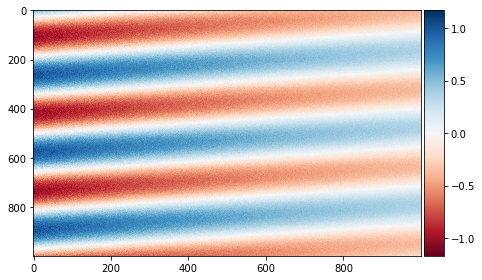

In [15]:
# The data we will try to approximate, a decaying, shifting sine wave

def f(t):
    N = 1000   # Number of states
    omega = 0.2
    decay_level = 0.1
    noise_level = 0.05
    x = np.linspace(-10,10,N)
    noise = noise_level*np.random.randn(N,len(t))
    decay = np.exp(-decay_level*t)
    return np.einsum('t,it->it', decay, np.sin(np.vstack(x) + omega*t) + noise)


t = np.linspace(0,10,1000)
dt = np.mean(np.diff(t))
data = f(t)
plot_data(data)


/opt/anaconda/envs/research/lib/python3.8/site-packages/pydmd/dmdbase.py:206: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  
/opt/anaconda/envs/research/lib/python3.8/site-packages/pydmd/dmdbase.py:240: SyntaxWarning: "is" with a literal. Did you mean "=="?
  
/opt/anaconda/envs/research/lib/python3.8/site-packages/pydmd/dmdbase.py:274: SyntaxWarning: "is" with a literal. Did you mean "=="?
  beta = np.divide(*sorted(X.shape))
/opt/anaconda/envs/research/lib/python3.8/site-packages/pydmd/dmdbase.py:215: UserWarning: Input data matrix X has condition number 847117.0120302689. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))


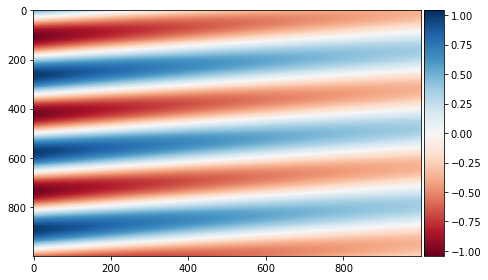

In [49]:
# The reference implementation, let it compute the optimum number of modes.
dmd_ = DMD_(svd_rank=0, tlsq_rank=0)
dmd_.fit(X=data)
plot_data(dmd_.reconstructed_data)

Rank truncation:  16


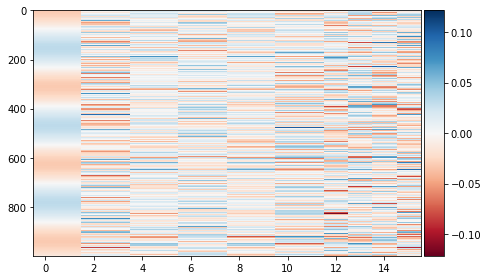

In [17]:
# Internal state
print("Rank truncation: ", dmd_.atilde.shape[1])
plot_data(dmd_.modes)

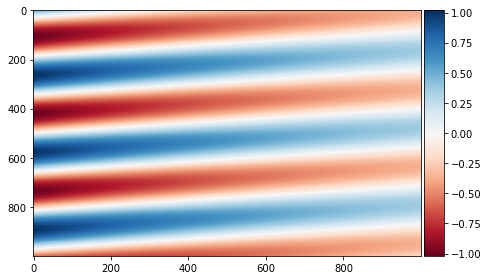

In [64]:
from csdmd.DMD import DMD

dmd = DMD(dt = dt, max_rank=16)

dmd.fit(data)

modes, b = dmd.compute_modes()
reconstructed = dmd.reconstruct(t)

plot_data(reconstructed)

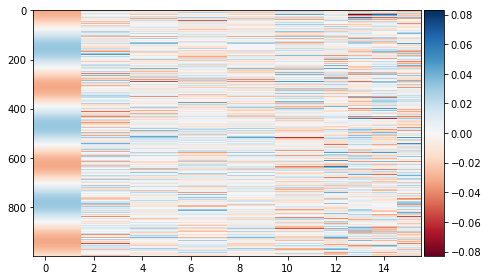

In [65]:
# Plot the modes
plot_data(dmd.phi)